In [1]:
# try to install ADCP processing tool

In [2]:
# Install some packages
!pip install gsw
!pip install ipywidgets

import os

### Install pycurrents
#Download 
!wget https://currents.soest.hawaii.edu/hg/pycurrents/archive/tip.zip
!unzip tip.zip 

# # Install
pycurrent_dir = [ directory for directory in os.listdir() if directory.startswith('pycurrents')][0]
pycurrent_dir

os.chdir(pycurrent_dir)
!pip install -e .
# os.chdir('/content/')

# Install pycurrents_ADCP_processing
!pip install git+https://github.com/JessyBarrette/pycurrents_ADCP_processing.git@hakai_dev

# Install process_ocean_timeseries
!pip install git+https://github.com/HakaiInstitute/process_ocean_timeseries.git

     |████████████████████████████████| 2.4 MB 5.1 MB/s 
--2021-09-30 18:54:22--  https://currents.soest.hawaii.edu/hg/pycurrents/archive/tip.zip
Resolving currents.soest.hawaii.edu (currents.soest.hawaii.edu)... 128.171.154.235
Connecting to currents.soest.hawaii.edu (currents.soest.hawaii.edu)|128.171.154.235|:443... connected.
HTTP request sent, awaiting response... 200 Script output follows
Length: unspecified [application/zip]
Saving to: ‘tip.zip’

tip.zip                 [    <=>             ]   2.19M  2.45MB/s    in 0.9s    

2021-09-30 18:54:25 (2.45 MB/s) - ‘tip.zip’ saved [2295447]

Archive:  tip.zip
  inflating: pycurrents-c22d6c40e594/.hg_archival.txt  
  inflating: pycurrents-c22d6c40e594/.hgignore  
  inflating: pycurrents-c22d6c40e594/.hgtags  
  inflating: pycurrents-c22d6c40e594/README.txt  
  inflating: pycurrents-c22d6c40e594/doc/INSTALL.txt  
  inflating: pycurrents-c22d6c40e594/doc/Makefile  
  inflating: pycurrents-c22d6c40e594/doc/conf.py  
  inflating: pycurrent

In [3]:
from process_ocean_data.tools import google, hakai, process, geo
import process_ocean_data.process_adcp_timeseries as process_adcp

from pycurrents_ADCP_processing import ADCP_processing_L0, ADCP_processing_L1
import xarray as xr
import pandas as pd
import numpy as np
import glob

from ipywidgets import widgets, interact
import plotly.express as px
import matplotlib.pyplot as plt


In [4]:
# Return to Google Colab initial directory
!cd /content/

# Retrieve Hakai ADCP Deployment Log
Apply transformations to Hakai log
- Convert times to datetime objects in UTC
- Retrieve instrument time offset from UTC
- Convert lat/long to decimal degrees
- Compute trilateration if available
- Retrieve Magnetic Declination
- Generate standard Hakai File Name

In [5]:
# File path
dest_dir = r"/content/processed_data/"
# Generate output directory if doesn't exist
if not os.path.exists(dest_dir):
     os.mkdir(dest_dir)

# Define Spreadsheet ID
# Hakai ADCP Deployment log
# The ID and range of a sample spreadsheet.
INSTRUMENT_LOG_LINK = 'https://docs.google.com/spreadsheets/d/1fg8QEdZIE1sSYf4lAM-p12LaiBs4Cli8CVJriwaeAFs/edit?usp=sharing'
SAMPLE_RANGE_NAME = 'ADCP Deployments!A:AZ'

# Get Hakai Instrument Log and convert it to a dataframe
df = google.get_from_google_public(INSTRUMENT_LOG_LINK)

# Apply transformations to Hakai log
#  - Convert times to datetime objects in UTC
#  - Retrieve instrument time offset from UTC
#  - Convert lat/long to decimal degrees
#  - Compute trilateration if available
#  - Retrieve Magnetic Declination
#  - Generate standard Hakai File Name
df = hakai.transform_hakai_log(df, dest_dir,get_mag_dec=True)

# Ignore entries with no data associated
df = df.dropna(subset=['Link to Raw Data'])


Retrieve Time Zone Internal Clock Sync or Start Time
Get Magnetic Declination Values from NRCAN
Triangulate deployment location


# Generate IOS Metadata File for each deployment

In [6]:
# Produce a metadata file for each Hakai ADCP Deployment based on the metadata variable mapping show below:
hakai.hakai_log_to_ios_csv(df, process_adcp.hakai_to_ios_map, dest_dir)


Empty Fields:
dict_keys(['cruise_description', 'deployment_cruise_number', 'return_cruise_number', 'deployment_number'])
From Hakai Log:
dict_keys(['anchor_type', 'anchor_drop_time', 'anchor_release_time', 'comment', 'geographic_area', 'latitude', 'longitude', 'station', 'platform', 'project', 'scientist', 'instrumentSubtype', 'serialNumber', 'magnetic_variation', 'instrument_clock_seconds_utc_offset'])
Default Values:
{'instrument_depth': '-99', 'country_institute_code': '-99', 'agency': 'Hakai Institute', 'water_depth': '-99', 'publisher_email': 'info@hakai.org', 'history': 'Magnetic Declination was retrieve for the specific location and deployment time from NRCAN website.', 'acknowledgement': 'Hakai Mooring Group', 'cut_lead_ensembles': 0, 'country': 'Canada', 'cut_trail_ensembles': 0}
Name
acknowledgement                                                      Hakai Mooring Group
agency                                                                   Hakai Institute
anchor_type      

In [7]:
# Retrieve Raw ADCP data from google drive (*.000)
raw_file_list = []
for id,row in df.iterrows():
    raw_file = os.path.join(dest_dir,row['file_name']+'.000')
    google.get_from_google_public(row['Link to Raw Data'], 
                                  os.path.join(dest_dir,row['file_name']+'.000'))
    raw_file_list.append(raw_file)

Download /content/processed_data/Hakai_RDI-ADCP-Workhorse-SN24621_Quadra-QuadraADCP_20190222-20190408.000: : 58.53125MB [00:00, 217.02MB/s]
Download /content/processed_data/Hakai_RDI-ADCP-Workhorse-SN24621_Calvert-KC6M_20190514-20190719.000: : 60.46875MB [00:00, 141.80MB/s]
Download /content/processed_data/Hakai_RDI-ADCP-Workhorse-SN24621_Calvert-KC6M_20190721-20190930.000: : 67.28125MB [00:00, 147.30MB/s]
Download /content/processed_data/Hakai_RDI-ADCP-Workhorse-SN24621_Calvert-KC6M_20191005.000: : 117.65625MB [00:00, 138.33MB/s]
Download /content/processed_data/Hakai_RDI-ADCP-Workhorse-SN24621_Calvert-KC6M_20200212-20200828.000: : 162.6875MB [00:00, 167.22MB/s]
Download /content/processed_data/Hakai_RDI-ADCP-Workhorse-SN18834_Calvert-Surf Pass_20200703-20200703.000: : 1.84375MB [00:00, 120.89MB/s]
Download /content/processed_data/Hakai_RDI-ADCP-Workhorse-SN18834_Calvert-West Beach_20200704.000: : 1.46875MB [00:00, 86.88MB/s]
Download /content/processed_data/Hakai_RDI-ADCP-Workhorse-S

Hakai_RDI-ADCP-Workhorse-SN24621_Quadra-QuadraADCP_20190222-20190408.adcp.L0.nc
Read in csv metadata file
Read in raw data
0
0
0
Assigning pressure variable
Assigning percent good variables
Pressure Offset [pre, post] = [0.017000000923871994, -0.11100000143051147]
Hakai_RDI-ADCP-Workhorse-SN24621_Quadra-QuadraADCP_20190222-20190408.adcp.L1.nc
wh
Read in csv metadata file
Read in raw data
np.max(counts): 41
counts[index_of_zero]: [2]
serial number: WH24621
Calculated sea surface height from sea pressure using gsw package
(53171, 50) (53171, 50)
[[0.14506575 0.15889837        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
[[0. 0

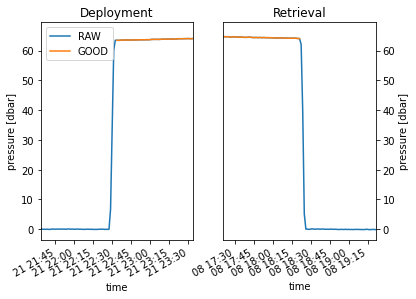

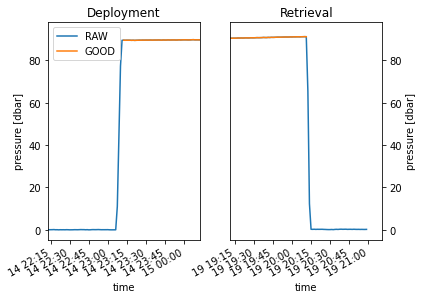

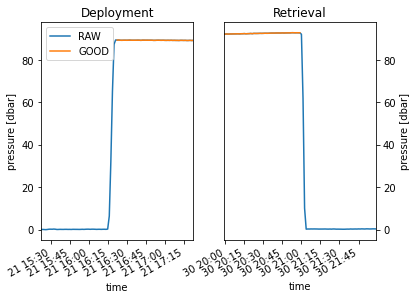

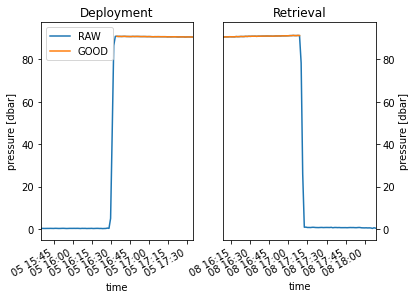

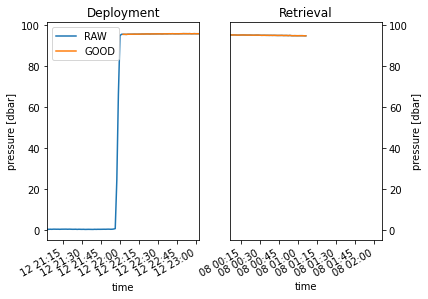

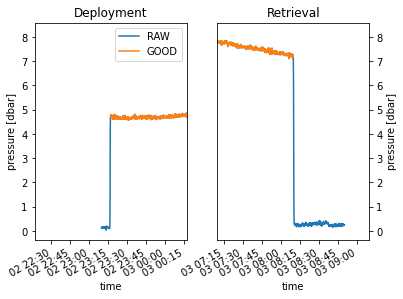

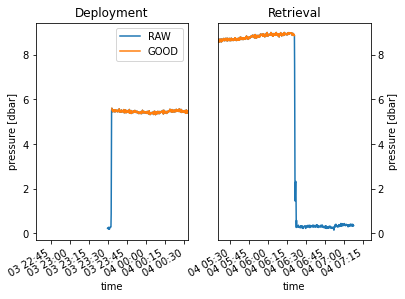

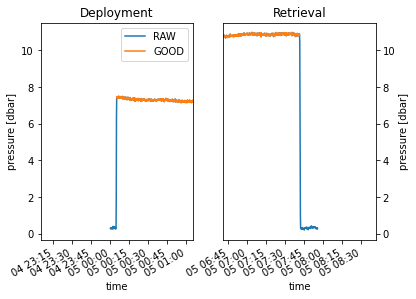

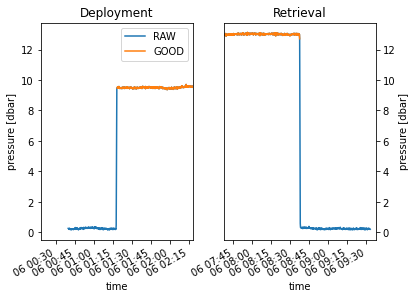

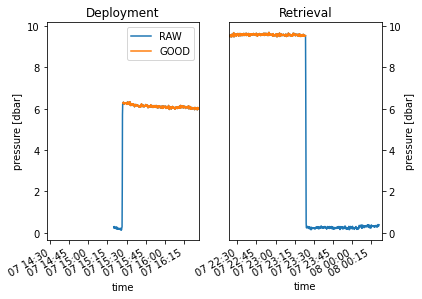

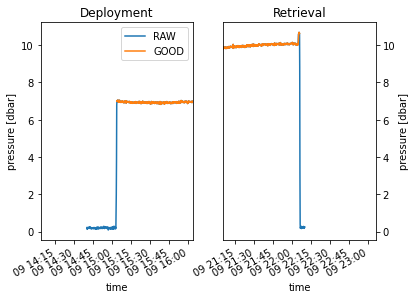

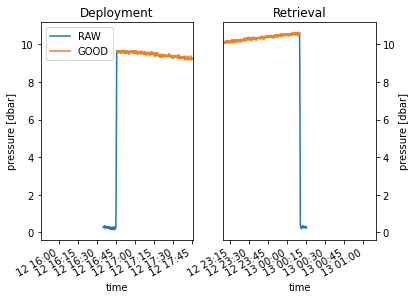

In [8]:
# Process each files automatically
for raw_file in raw_file_list:
    meta_file = raw_file[0:-4] + '_meta.csv'
    process_adcp.process_hakai_adcp(raw_file, meta_file, dest_dir)

# Review File


In [25]:
# Retrieve list of NetCDF files available
files = os.listdir(dest_dir)
files = [file for file in files if file.endswith('.nc')]

# Define a
file_selector = widgets.Dropdown(
    options=sorted(files),
    value=files[0],
    description='Select File to Review:',
    disabled=False,
)

ds = xr.open_dataset(os.path.join(dest_dir,files[0]))

def plot_adcp(file,variable, apply_flag):

    ds = xr.open_dataset(os.path.join(dest_dir,file_selector.value))
    fig,ax = plt.subplots(ncols=1)
    fig.set_size_inches(15,6)
    try:    
        if apply_flag:
            if variable+'_QC' in ds :
                ds[variable].where(ds[variable+'_QC']==1,drop=True).plot(robust=True,axes=ax)
            elif len(ds[variable].dims)>1:
                ds[variable].where(ds['LCEWAP01_QC']==1,drop=True).plot(robust=True,axes=ax)
            else:
                ds[variable].where((ds['LCEWAP01_QC']==1).any(dim='distance'),drop=True).plot(axes=ax)
        else:
            ds[variable].plot(robust=True,axes=ax)
    except:
        print('failed')
        ds[variable].plot(axes=ax)
    
    plt.tight_layout()
    plt.draw()

interact(plot_adcp,file=file_selector,variable=ds.keys(),apply_flag=True)

interactive(children=(Dropdown(description='Select File to Review:', index=5, options=('Hakai_RDI-ADCP-Workhor…

<function __main__.plot_adcp>

# Download Data
Zip all data together and use the Google interface to retrieve and download the zipped file.


In [10]:
# Zip all processed data to be ready to download
!zip -r /content/processed_data.zip /content/processed_data/ 

  adding: content/processed_data/ (stored 0%)
  adding: content/processed_data/Hakai_RDI-ADCP-Workhorse-SN18834_Calvert-Starfish_20200712.adcp.L1_Hakai.nc (deflated 85%)
  adding: content/processed_data/Hakai_RDI-ADCP-Workhorse-SN18834_Calvert-Starfish_20200712_meta_L1.csv (deflated 56%)
  adding: content/processed_data/Hakai_RDI-ADCP-Workhorse-SN18834_Calvert-West Beach_20200704.adcp.L0_start_end.png (deflated 11%)
  adding: content/processed_data/Hakai_RDI-ADCP-Workhorse-SN18834_Calvert-Starfish_20200709.000 (deflated 50%)
  adding: content/processed_data/Hakai_RDI-ADCP-Workhorse-SN24621_Calvert-KC6M_20190721-20190930_meta_L1.csv (deflated 58%)
  adding: content/processed_data/Hakai_RDI-ADCP-Workhorse-SN18834_Calvert-Triquetta_20200705_meta.csv (deflated 56%)
  adding: content/processed_data/Hakai_RDI-ADCP-Workhorse-SN18834_Calvert-Triquet_20200707.adcp.L1_Hakai.nc (deflated 84%)
  adding: content/processed_data/Hakai_RDI-ADCP-Workhorse-SN24621_Calvert-KC6M_20191005.000 (deflated 45%